In [1]:
# Modern imports with additional libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Enhanced NLP preprocessing
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder

# Modern ML libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                           accuracy_score, f1_score, roc_auc_score, roc_curve)
from sklearn.pipeline import Pipeline

# Downloaded necessary NLTK data
# nltk.download('stopwords', quiet=True)
# nltk.download('wordnet', quiet=True)
# nltk.download('punkt', quiet=True)
# nltk.download('omw-1.4', quiet=True)

print("**All libraries imported successfully!")


**All libraries imported successfully!


In [ ]:
# Enhanced data loading with error handling (Defensive programming)
try:
    df = pd.read_csv('train.csv')
    print(f"**Data loaded successfully! Shape: {df.shape}")
    print(f"**Dataset info:")
    print(df.info())
    print(f"\n** Target distribution:")
    print(df['Is_Response'].value_counts())
except FileNotFoundError:
    print("X Error: train.csv not found. Please check file path.")
    
# Display first few rows for understanding
df.head()


**Data loaded successfully! Shape: (38932, 5)
**Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38932 entries, 0 to 38931
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   User_ID       38932 non-null  object
 1   Description   38932 non-null  object
 2   Browser_Used  38932 non-null  object
 3   Device_Used   38932 non-null  object
 4   Is_Response   38932 non-null  object
dtypes: object(5)
memory usage: 1.5+ MB
None

** Target distribution:
Is_Response
happy        26521
not happy    12411
Name: count, dtype: int64


,User_ID,Description,Browser_Used,Device_Used,Is_Response
0,id10326,The room was kind of clean but had a VERY stro...,Edge,Mobile,not happy
1,id10327,I stayed at the Crown Plaza April -- - April -...,Internet Explorer,Mobile,not happy
2,id10328,I booked this hotel through Hotwire at the low...,Mozilla,Tablet,not happy
3,id10329,Stayed here with husband and sons on the way t...,InternetExplorer,Desktop,happy
4,id10330,My girlfriends and I stayed here to celebrate ...,Edge,Tablet,not happy


In [12]:
# Data preprocessing pipeline
class TextPreprocessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
    
    def preprocess_text(self, text):
        """Enhanced text preprocessing with modern techniques"""
        if pd.isna(text):    # Return empty string for NaN values
            return ""
        
        # Convert to lowercase
        text = str(text).lower()
        
        # Remove URLs, mentions, and hashtags
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'@\w+|#\w+', '', text)
        
        # Remove except(^) letters and whitespace
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        
        # Tokenize and remove stopwords
        words = text.split() # splits on whitespaces
        words = [self.lemmatizer.lemmatize(word) for word in words 
                if word not in self.stop_words and len(word) > 2]
        
        return ' '.join(words) # Join words back into a single string

# Initialize preprocessor
preprocessor = TextPreprocessor()

# Apply preprocessing
print("**Preprocessing text data...")
df_clean = df.copy()

# Remove duplicates with better reporting
initial_shape = df_clean.shape[0] 
df_clean = df_clean.drop_duplicates(keep='first')
duplicates_removed = initial_shape - df_clean.shape[0]
print(f"**Removed {duplicates_removed} duplicate rows")

# Handle missing values
df_clean = df_clean.dropna(subset=['Description', 'Is_Response']) # Ensure no NaN in key columns

# Apply text preprocessing
df_clean['processed_text'] = df_clean['Description'].apply(preprocessor.preprocess_text)

# Encode target variable
encoder = LabelEncoder()
df_clean['target'] = encoder.fit_transform(df_clean['Is_Response'])

print(f"**Preprocessing complete! Final shape: {df_clean.shape}")
print(f"**Sample processed text:")
print(df_clean[['Description', 'processed_text']].head(2))

df_clean.head(1)


**Preprocessing text data...
**Removed 0 duplicate rows
**Preprocessing complete! Final shape: (38932, 7)
**Sample processed text:
                                         Description  \
0  The room was kind of clean but had a VERY stro...   
1  I stayed at the Crown Plaza April -- - April -...   

                                      processed_text  
0  room kind clean strong smell dog generally ave...  
1  stayed crown plaza april april staff friendly ...  


,User_ID,Description,Browser_Used,Device_Used,Is_Response,processed_text,target
0,id10326,The room was kind of clean but had a VERY stro...,Edge,Mobile,not happy,room kind clean strong smell dog generally ave...,1


In [ ]:
# train-test split with stratification
X = df_clean['processed_text']
y = df_clean['target']

# Stratified split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,  # Modern standard: 80-20 split
    random_state=42,  # Reproducibility, same split every time
    stratify=y  # Maintain class distribution in training and test sets
)

print(f"** Training set size: {X_train.shape[0]}")
print(f"** Test set size: {X_test.shape[0]}")
print(f"** Training set distribution:\n{pd.Series(y_train).value_counts()}") 
# y_train and y_test are numpy arrays, need pd.Series for value_counts()
print(f"** Test set distribution:\n{pd.Series(y_test).value_counts()}")


** Training set size: 31145
** Test set size: 7787
** Training set distribution:
target
0    21216
1     9929
Name: count, dtype: int64
** Test set distribution:
target
0    5305
1    2482
Name: count, dtype: int64


In [ ]:
import joblib
import os

# Modern model pipeline with multiple algorithms
def create_models():
    """Create multiple model pipelines for comparison"""
    
    models = {
        'Logistic Regression': Pipeline([
            ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
            ('classifier', LogisticRegression(random_state=42, max_iter=1000))
        ]),
        
        'Random Forest': Pipeline([
            ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
            ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
        ])
    }
    
    return models

# Simple load/train logic
if os.path.exists('sentiment_models.pkl'):
    data = joblib.load('sentiment_models.pkl')
    results = data['results'] # Dictionary of model results
    encoder = data['encoder'] # for converting target labels back to original
    preprocessor = data['preprocessor'] 
    print("** Saved Models loaded!")
else:
    print("** Training models...")
    
    # Train and evaluate models
    models = create_models()  # Create model pipelines
    results = {}  # Initialize results dictionary

    for name, model in models.items():  # models.items(): returns (name, model) pairs
        print(f"\n Training {name}...")
        
        # Train model
        model.fit(X_train, y_train)
        
        # Pipeline execution: Text → TF-IDF → Classification
        # Why Pipeline: Ensures preprocessing and training happen together
        # TfidfVectorizer is part of the pipeline, so no need to fit_transform separately

        # Make predictions
        y_pred = model.predict(X_test)  # Numpy array of predicted classes
        y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
        # predict_proba returns probabilities for each class, we take the second column for positive class
        # ROC/AUC calculations require probability scores

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        # Cross-validation for more robust evaluation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy') 
        # StratifiedKFold is used by default in cross_val_score
        
    
        # Store results in a dictionary for easy access and future reference
        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'f1_score': f1,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(), #Low values indicate stable performance
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }
        
        print(f"** {name} Results:")
        print(f"   Accuracy: {accuracy:.4f}")
        print(f"   F1-Score: {f1:.4f}")
        print(f"   CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        # Confidence interval: ±2 standard deviations covers ~95% of expected performance
        # Accuracy vs CV: Large difference suggests overfitting


    # Save everything with one line
    joblib.dump({'results': results, 'encoder': encoder, 'preprocessor': preprocessor}, 'sentiment_models.pkl')
    print(" Models saved!")


** Saved Models loaded!


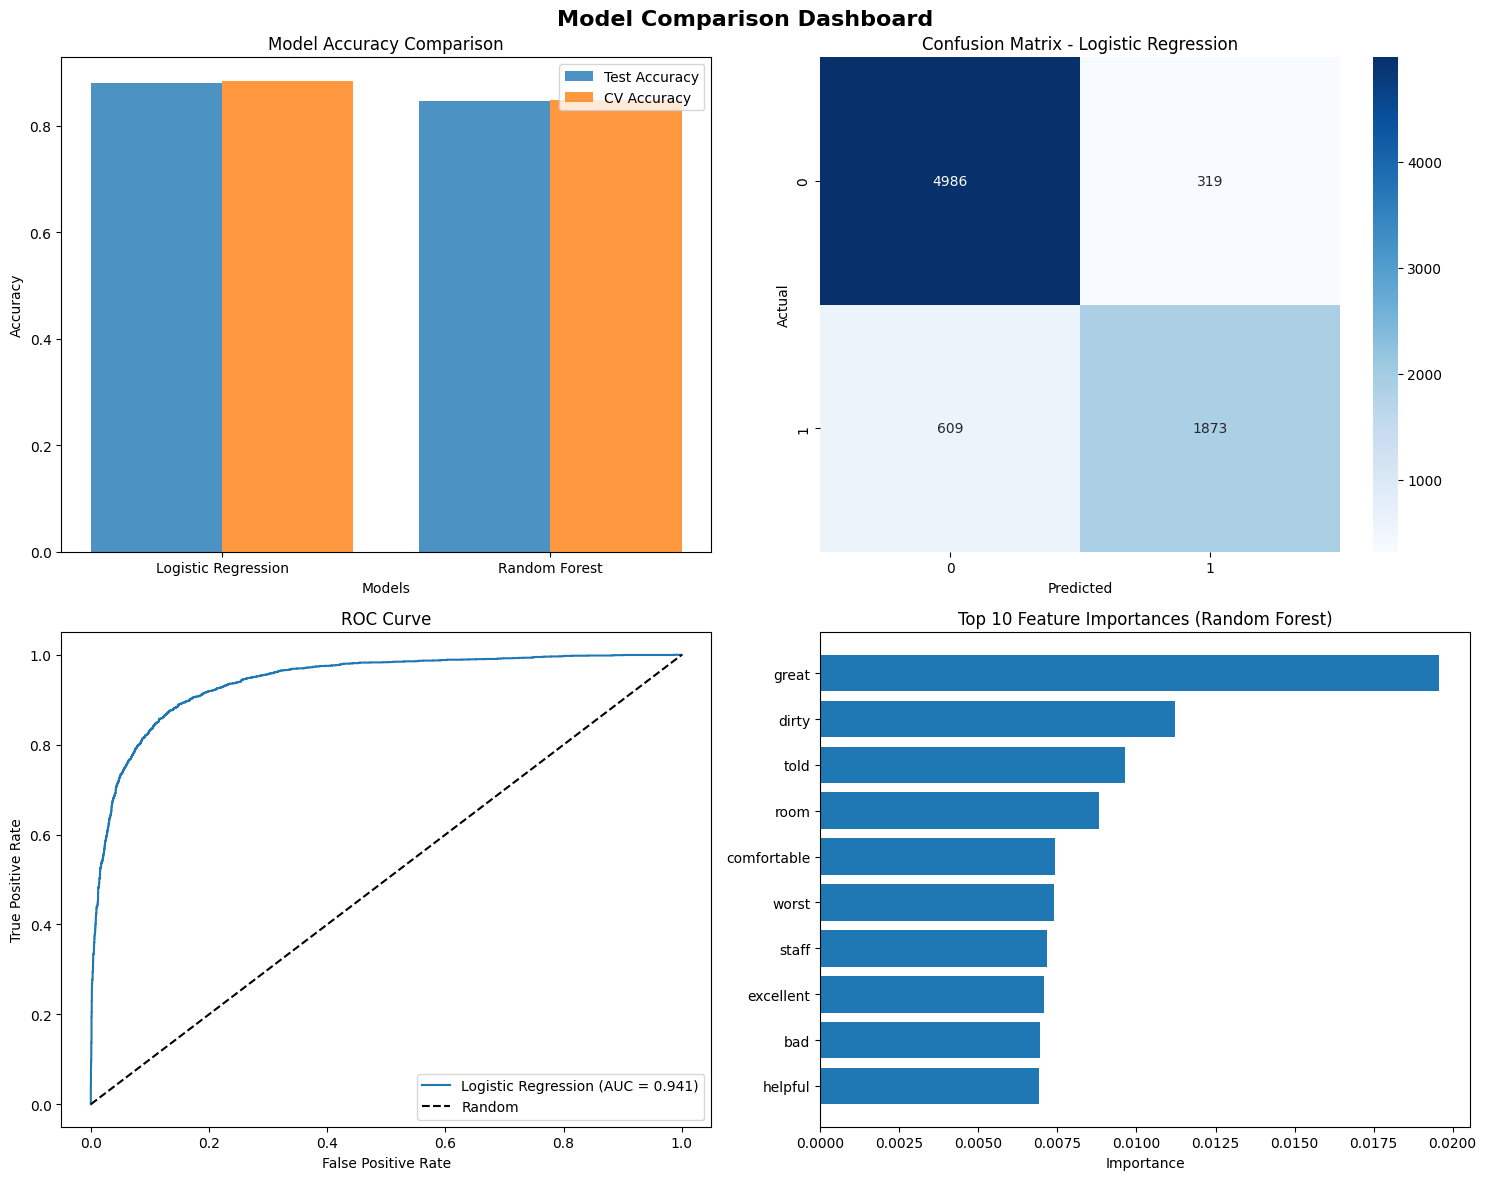


** DETAILED CLASSIFICATION REPORTS:

** Logistic Regression Detailed Metrics:
              precision    recall  f1-score   support

     Class 0       0.89      0.94      0.91      5305
     Class 1       0.85      0.75      0.80      2482

    accuracy                           0.88      7787
   macro avg       0.87      0.85      0.86      7787
weighted avg       0.88      0.88      0.88      7787


** Random Forest Detailed Metrics:
              precision    recall  f1-score   support

     Class 0       0.84      0.96      0.90      5305
     Class 1       0.89      0.59      0.71      2482

    accuracy                           0.85      7787
   macro avg       0.86      0.78      0.80      7787
weighted avg       0.85      0.85      0.84      7787



In [ ]:
# Modern visualization and evaluation
def plot_comprehensive_results(results, y_test):
    """Create comprehensive evaluation plots"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12)) # 4 plots in a 2x2 grid, width=15, height=12
    fig.suptitle('Model Comparison Dashboard', fontsize=16, fontweight='bold')
    
    # 1. Accuracy Comparison
    model_names = list(results.keys())
    accuracies = [results[name]['accuracy'] for name in model_names]
    cv_means = [results[name]['cv_mean'] for name in model_names]
    
    # test vs CV: Identifies potential overfitting (large gap indicates model memorized training data)

    x_pos = np.arange(len(model_names))
    axes[0,0].bar(x_pos - 0.2, accuracies, 0.4, label='Test Accuracy', alpha=0.8)
    axes[0,0].bar(x_pos + 0.2, cv_means, 0.4, label='CV Accuracy', alpha=0.8)
    axes[0,0].set_xlabel('Models')
    axes[0,0].set_ylabel('Accuracy')
    axes[0,0].set_title('Model Accuracy Comparison')
    axes[0,0].set_xticks(x_pos)
    axes[0,0].set_xticklabels(model_names)
    axes[0,0].legend()
    
    # 2. Confusion Matrix for best model
    best_model_name = max(results.keys(), key=lambda x: results[x]['accuracy'])
    best_predictions = results[best_model_name]['predictions']
    
    cm = confusion_matrix(y_test, best_predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,1])
    axes[0,1].set_title(f'Confusion Matrix - {best_model_name}')
    axes[0,1].set_xlabel('Predicted')
    axes[0,1].set_ylabel('Actual')
    
    # 3. ROC Curve (if probabilities available)
    if results[best_model_name]['probabilities'] is not None:
        fpr, tpr, _ = roc_curve(y_test, results[best_model_name]['probabilities']) 
         # returns fpr, tpr, thresholds
        auc_score = roc_auc_score(y_test, results[best_model_name]['probabilities']) 
        # 0.5 is random, 1.0 is perfect
        
        axes[1,0].plot(fpr, tpr, label=f'{best_model_name} (AUC = {auc_score:.3f})')
        axes[1,0].plot([0, 1], [0, 1], 'k--', label='Random') 
        axes[1,0].set_xlabel('False Positive Rate')
        axes[1,0].set_ylabel('True Positive Rate')
        axes[1,0].set_title('ROC Curve')
        axes[1,0].legend()

    # ROC curve is better for imbalanced datasets, as it focuses on the trade-off between
    # Shows relationship b/w Sensitivity (tpr) and Specificity (fpr)

    # 4. Feature Importance (for tree-based models)
    if 'Random Forest' in results:
        rf_model = results['Random Forest']['model']
        feature_names = rf_model.named_steps['tfidf'].get_feature_names_out()
        importances = rf_model.named_steps['classifier'].feature_importances_
        
        
        # Sorted lowest to highest(indices(last 10 highest importance features))
        top_indices = np.argsort(importances)[-10:] 
        # Maps indices to feature names
        top_features = [feature_names[i] for i in top_indices]
        top_importances = importances[top_indices] 
        
        axes[1,1].barh(range(len(top_features)), top_importances) # Horizontal bar chart
        axes[1,1].set_yticks(range(len(top_features)))
        axes[1,1].set_yticklabels(top_features)
        axes[1,1].set_xlabel('Importance')
        axes[1,1].set_title('Top 10 Feature Importances (Random Forest)')
    
    plt.tight_layout() # Automatically adjusts layout to prevent overlap/ use plt.subplots_adjust()
    plt.show()

# Generate comprehensive results
plot_comprehensive_results(results, y_test)

# Print detailed classification reports
print("\n** DETAILED CLASSIFICATION REPORTS:")
print("="*50)

for name, result in results.items():
    print(f"\n** {name} Detailed Metrics:")
    print(classification_report(y_test, result['predictions'], 
                              target_names=['Class 0', 'Class 1']))


In [36]:
# Modern prediction function with confidence scores
def predict_sentiment(text, model_name='Logistic Regression'):
    """
    Predict sentiment for new text with confidence score
    """
    if model_name not in results:
        print(f"** Model '{model_name}' not found!")
        return None
    
    model = results[model_name]['model']
    
    # Preprocess the input text
    processed_text = preprocessor.preprocess_text(text) # Same preprocessor as training data
    
    # Make prediction
    prediction = model.predict([processed_text])[0] 
    
    # Get confidence if available
    if hasattr(model, 'predict_proba'):
        confidence = model.predict_proba([processed_text])[0].max()
        
        result = {
            'text': text,
            'processed_text': processed_text,
            'prediction': int(prediction),
            # prediction is a numpy int64, converted to int for JSON compatibility 
            'prediction_label': encoder.inverse_transform([prediction])[0], 
            # encoder.inverse_transform converts numerical label back to original class
            'confidence': f"{confidence:.2%}" # 2 decimal places for percentage
        }
    else:
        result = {
            'text': text,
            'processed_text': processed_text,
            'prediction': int(prediction),
            'prediction_label': encoder.inverse_transform([prediction])[0],
            'confidence': 'N/A'
        }
    
    return result

# Test the prediction function
test_texts = [
    "I love this product, it's amazing!",
    "This is terrible, I do not like it",
    "The service was nothing but special"
]

print("** PREDICTION EXAMPLES:")
print("="*50)

for text in test_texts:
    result = predict_sentiment(text)
    if result:
        print(f"\n** Text: '{result['text']}'")
        print(f"** Processed: '{result['processed_text']}'")
        print(f"** Prediction: {result['prediction_label']}")
        print(f"** Confidence: {result['confidence']}")


** PREDICTION EXAMPLES:

** Text: 'I love this product, it's amazing!'
** Processed: 'love product amazing'
** Prediction: happy
** Confidence: 98.63%

** Text: 'This is terrible, I do not like it'
** Processed: 'terrible like'
** Prediction: not happy
** Confidence: 97.16%

** Text: 'The service was nothing but special'
** Processed: 'service nothing special'
** Prediction: not happy
** Confidence: 91.13%


In [ ]:
# Load your test data
test_df = pd.read_csv('test.csv')

# Apply your trained model to all descriptions
predictions = []
confidences = []

for description in test_df['Description']:
    result = predict_sentiment(description, model_name='Logistic Regression')
    if result:
        predictions.append(result['prediction_label'])
        confidences.append(result['confidence'])
    else:
        predictions.append('unknown')
        confidences.append('0%')

# Add predictions to your dataframe
test_df['predicted_sentiment'] = predictions
test_df['confidence'] = confidences



In [38]:
# Save the results to a new CSV file
output_file = 'test_predictions.csv'
test_df.to_csv(output_file, index=False)
print(f"** Predictions saved to {output_file}")
# Display the first few rows of the predictions
print("\n** Sample Predictions:")
print(test_df[['Description', 'predicted_sentiment', 'confidence']].head(5))


** Predictions saved to test_predictions.csv

** Sample Predictions:
                                         Description predicted_sentiment  \
0  Looking for a motel in close proximity to TV t...           not happy   
1  Walking distance to Madison Square Garden and ...               happy   
2  Visited Seattle on business. Spent - nights in...               happy   
3  This hotel location is excellent and the rooms...           not happy   
4  This hotel is awesome I love the service Antho...               happy   

  confidence  
0     87.10%  
1     95.69%  
2     75.99%  
3     76.66%  
4     99.74%  
